In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import time as time

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-stock-data/GOOGL.csv


In [3]:
!pip install -q pmdarima ## auto arima library
!pip install -q pykan  ## KAN library
!pip install -q lightning  ## Lightning module for torch

In [44]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from kan import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD

from scipy import stats

import lightning as L

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [5]:
df_goog = pd.read_csv('/kaggle/input/google-stock-data/GOOGL.csv')
print(f'shape of the data: {df_goog.shape}')
df_goog.head()

shape of the data: (4431, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [6]:
df_goog.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
df_goog.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df = df_goog.drop('Adj Close',axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,9188602


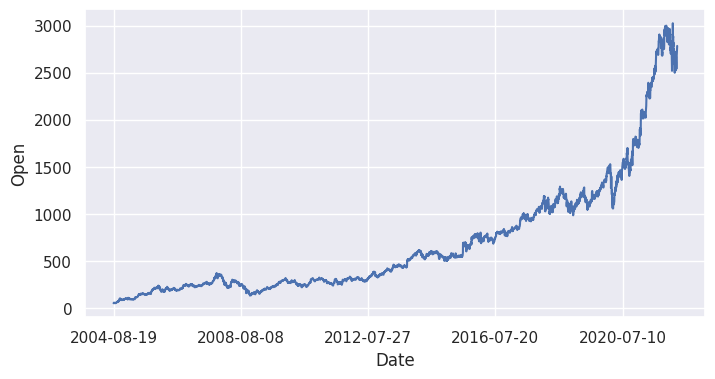

In [9]:
sns.set(context='notebook',style='darkgrid')

fig,ax = plt.subplots(1,1,figsize=(8,4))

sns.lineplot(data=df,x='Date',y='Open',ax=ax)

ax.set(xticks=df['Date'].iloc[::1000])

plt.show()

In [10]:
df['Daily Change'] = df['Close'].diff()
df['Return'] = df['Close'] / df['Close'].shift(1)
df['Log Return'] = np.log(df['Return'])
df.head()

,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,44659096,NaN,NaN,NaN
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,22834343,3.988990,1.079430,0.076433
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,18256126,0.545544,1.010064,0.010013
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,15247337,-2.267265,0.958592,-0.042289
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,9188602,0.565567,1.010775,0.010718


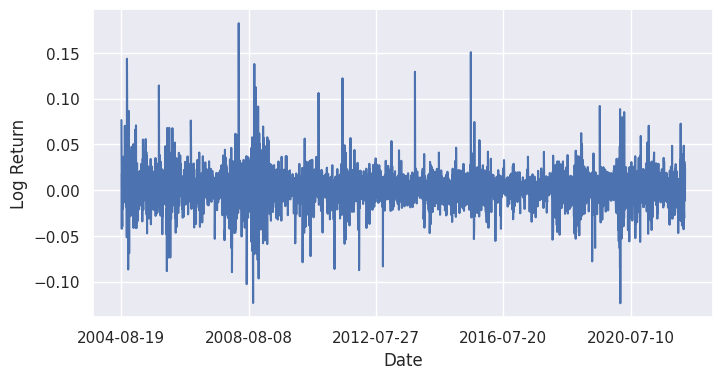

In [11]:
sns.set(context='notebook',style='darkgrid')

fig,ax = plt.subplots(1,1,figsize=(8,4))

sns.lineplot(data=df,x='Date',y='Log Return',ax=ax)

ax.set(xticks=df['Date'].iloc[::1000])

plt.show()

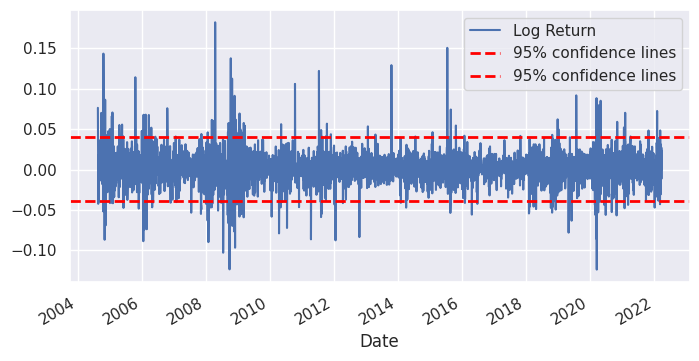

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

df.plot('Date','Log Return',ax=ax)

meanGain,stdGain = df['Log Return'].mean(),np.sqrt(df['Log Return'].var())
seMeanGain = stdGain/np.sqrt(df.shape[0])
seForecastGain = np.sqrt(stdGain**2 + seMeanGain**2)

gP95,gM95 = meanGain + 2.093*seForecastGain, meanGain - 2.093*seForecastGain
gP50,gM50 = meanGain + 0.688*seForecastGain, meanGain - 0.688*seForecastGain

# plt.hlines(y=[gP95,gM95],xmin=df['Date'].min(),xmax=df['Date'].max(),color='red',ls='dashed',lw=2)

ax.axhline(gP95,color='red',ls='dashed',lw=2,label='95% confidence lines')
ax.axhline(gM95,color='red',ls='dashed',lw=2,label='95% confidence lines')

plt.legend()

plt.show()

## Too many observations outside 95% confidence interval, which are calculated under the assumption that the gains are independent and are distributed normally. Therefore, there are two possibilities. The most logical guess would be that the gains are not independent (volatility clustering).

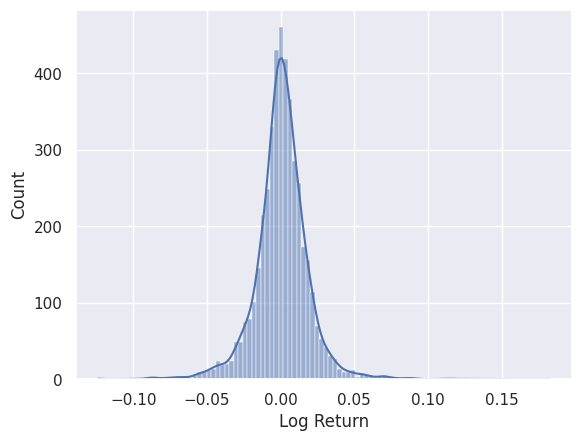

In [41]:
sns.histplot(data=df,x='Log Return',kde=True,bins=100)
plt.show()

In [42]:
autocorr = []
for i in range(1,df.shape[0]-2000):
    autocorr.append(df['Log Return'].autocorr(lag=i))

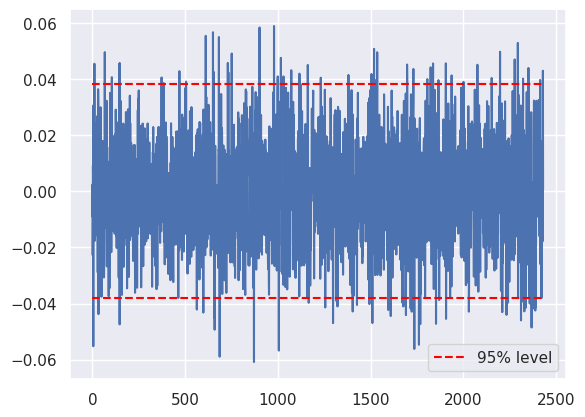

In [43]:
plt.plot(autocorr)

meanCorr,stdCorr = np.mean(autocorr),np.std(autocorr)
seMeanCorr = stdCorr/np.sqrt(len(autocorr))
seForecastCorr = np.sqrt(stdCorr**2 + seMeanCorr**2)

c95 = 2.093*seForecastCorr
c50 = 0.688*seForecastCorr

plt.hlines(y=[-c95,c95],xmin=0,xmax=len(autocorr),color='red',ls='dashed',label='95% level')
plt.legend()
plt.show()

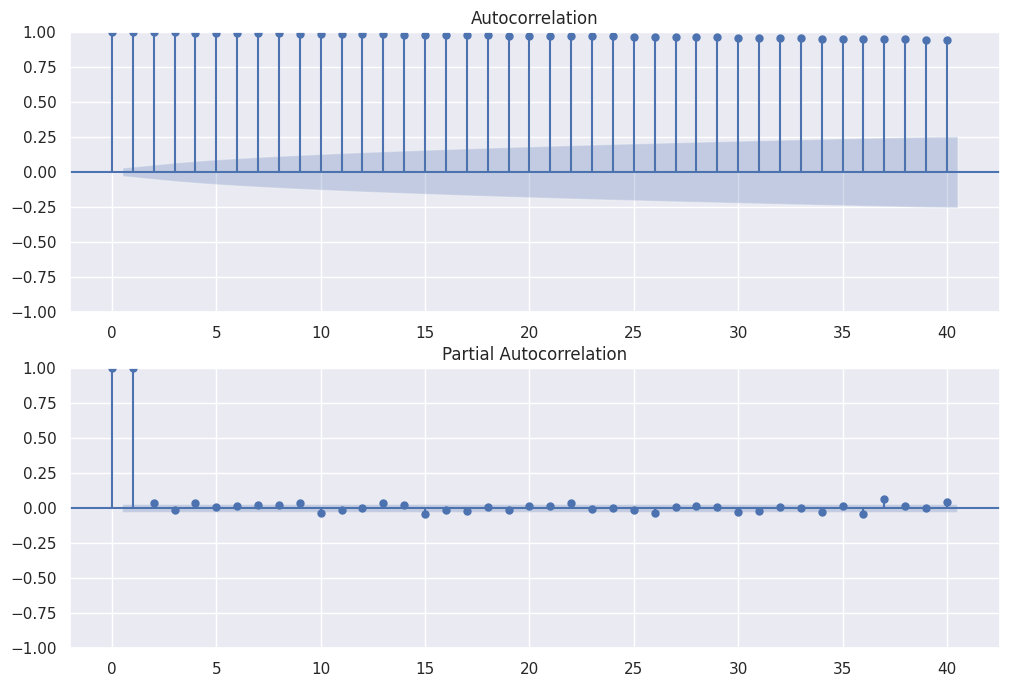

In [12]:
Feature = 'Close'
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df[Feature].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df[Feature], lags=40, ax=ax2)

### ARIMA on pre-2020-crash era

In [12]:
era_mask = (df['Date'].dt.year >= 2012) & (df['Date'].dt.year < 2020)

df_era = df[era_mask].reset_index(drop=True)

print(f'shape of the data is: {df_era.shape}')
df_era.head()

shape of the data is: (2012, 9)


,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return
0,2012-01-03,326.796783,334.409424,326.511505,333.038025,7345647,9.764740,1.030206,0.029759
1,2012-01-04,332.847839,335.460449,330.640656,334.474487,5722272,1.436462,1.004313,0.004304
2,2012-01-05,331.396393,332.317322,328.443451,329.834839,6559234,-4.639648,0.986129,-0.013969
3,2012-01-06,329.904907,330.330322,325.220215,325.335327,5380414,-4.499512,0.986358,-0.013736
4,2012-01-09,323.573578,323.823822,310.925934,311.541534,11633555,-13.793793,0.957601,-0.043324


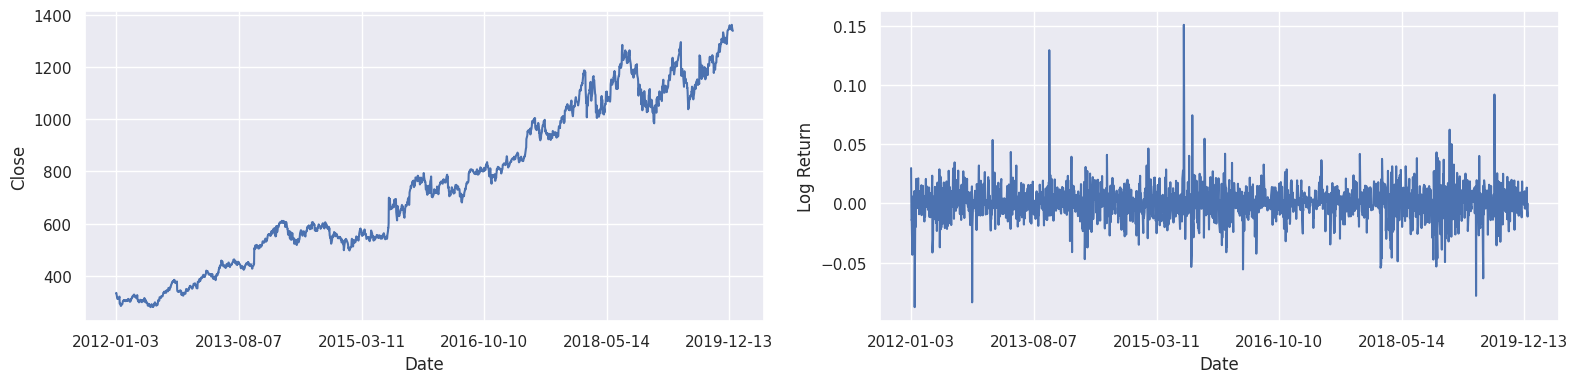

In [13]:
sns.set(context='notebook',style='darkgrid')

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df_era,x='Date',y='Close',ax=ax0)
sns.lineplot(data=df_era,x='Date',y='Log Return',ax=ax1)

ax0.set(xticks=df_era['Date'].iloc[::400])
ax1.set(xticks=df_era['Date'].iloc[::400])

plt.tight_layout()
plt.show()

In [14]:
def mse_loss(y_true,y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

df_copy = df_era.copy()
loss_dict = {}
loss_dict_MA = {}

In [15]:
## Train-test split

train_test_split_ratio = 0.8
split_indx = int(df_copy.shape[0]*train_test_split_ratio)

df_train = df_copy['Close'].iloc[:split_indx]
df_test = df_copy['Close'].iloc[split_indx:]
df_train.shape, df_test.shape

((1609,), (403,))

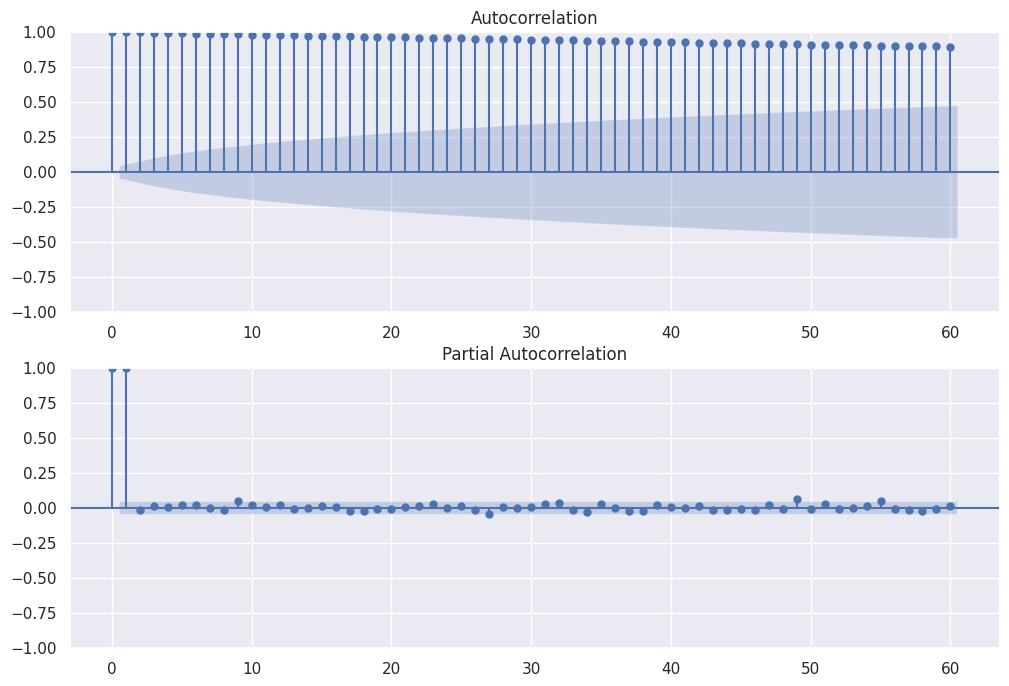

In [36]:
#Feature = 'Close'
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train.values.squeeze(), lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=60, ax=ax2)

In [37]:
auto_arima = pm.auto_arima(df_train,stepwise=False,seasonal=False)
auto_arima

ARIMA(order=(4, 1, 1), scoring_args={}, suppress_warnings=True)

In [38]:
forecast_auto = auto_arima.predict(n_periods=len(df_test))

df_copy['forecast_auto_90'] = [None]*len(df_train) + list(forecast_auto)

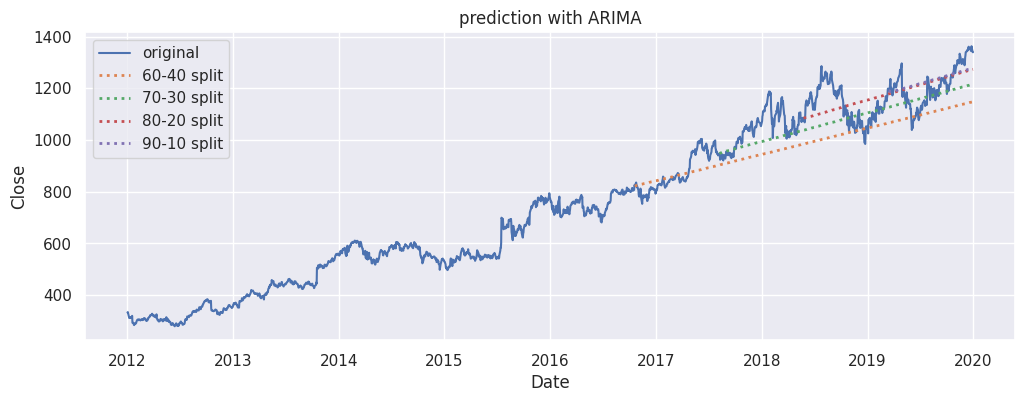

In [39]:
fig,ax = plt.subplots(1,1,figsize=(12,4))

sns.lineplot(data=df_era,x='Date',y='Close',ax=ax,label='original')


for i in range(60,91,10):
    feature = 'forecast_auto_'+str(i)
    label = f'{i}-{100-i} split'
    sns.lineplot(x=df_era['Date'].iloc[df_copy[feature].isnull().values.sum():],y=df_copy[feature],ls='dotted',lw=2,label=label,ax=ax)

ax.set(title='prediction with ARIMA')

ax.legend()

plt.show()

In [40]:
mse_loss_val = mse_loss(df_test,forecast_auto)
print(mse_loss_val)

loss_dict['90'] = mse_loss_val

64.50199786090636


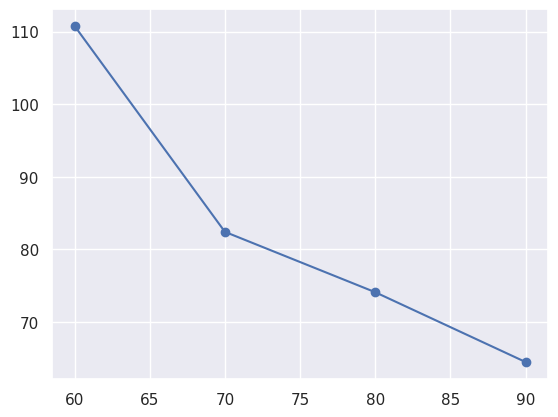

In [41]:
#loss_data = np.array(loss_
plt.plot(range(60,91,10),list(loss_dict.values()),'-o')

plt.show()

In [21]:
window_size = 50

train_arima = df_copy['Close'].iloc[:split_indx+window_size]
test_arima = df_copy['Close'].iloc[split_indx+window_size:]

model_arima = ARIMA(train_arima,order=(4,1,1)).fit()
model_auto_arima = pm.auto_arima(train_arima,stepwise=False,seasonal=False)
predictions_arima = model_arima.forecast(steps=len(test_arima))
predictions_auto_arima = model_auto_arima.predict(n_periods=len(test_arima))

In [22]:
model_auto_arima

ARIMA(order=(4, 1, 1), scoring_args={}, suppress_warnings=True)

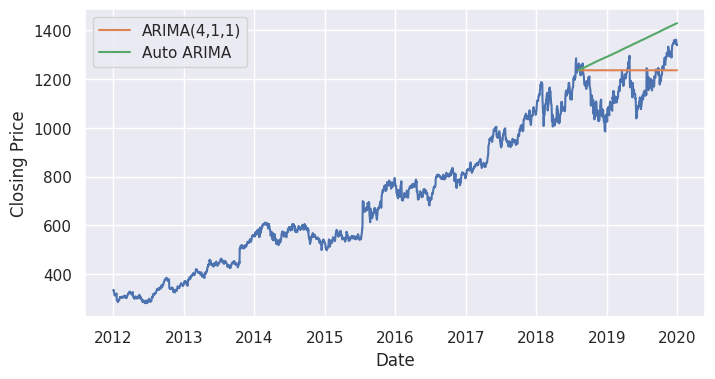

In [23]:
plt.figure(figsize=(8,4))

plt.plot(df_copy['Date'],df_copy['Close'])
plt.plot(df_copy['Date'].iloc[split_indx+window_size:], predictions_arima,label='ARIMA(4,1,1)')
plt.plot(df_copy['Date'].iloc[split_indx+window_size:], predictions_auto_arima,label='Auto ARIMA')

plt.gca().set(xlabel='Date',ylabel='Closing Price')
plt.legend()

plt.show()

In [24]:
print(f'The error in the ARIMA(4,1,1) model : {mse_loss(test_arima,predictions_arima)}')
print(f'The error in the Auto ARIMA model : {mse_loss(test_arima,predictions_auto_arima)}')

The error in the ARIMA(4,1,1) model : 104.37277501592419
The error in the Auto ARIMA model : 173.85438990798443


### ARIMA on rolling average

In [25]:
df_copy['SMA(12)'] = df_copy['Close'].rolling(window=12).mean()
df_copy['EMA'] = df_copy['Close'].ewm(span=20,adjust=True).mean()
df_copy.head()

,Date,Open,High,Low,Close,Volume,Daily Change,Return,Log Return,SMA(12),EMA
0,2012-01-03,326.796783,334.409424,326.511505,333.038025,7345647,9.764740,1.030206,0.029759,NaN,333.038025
1,2012-01-04,332.847839,335.460449,330.640656,334.474487,5722272,1.436462,1.004313,0.004304,NaN,333.792168
2,2012-01-05,331.396393,332.317322,328.443451,329.834839,6559234,-4.639648,0.986129,-0.013969,NaN,332.339060
3,2012-01-06,329.904907,330.330322,325.220215,325.335327,5380414,-4.499512,0.986358,-0.013736,NaN,330.317191
4,2012-01-09,323.573578,323.823822,310.925934,311.541534,11633555,-13.793793,0.957601,-0.043324,NaN,325.775519


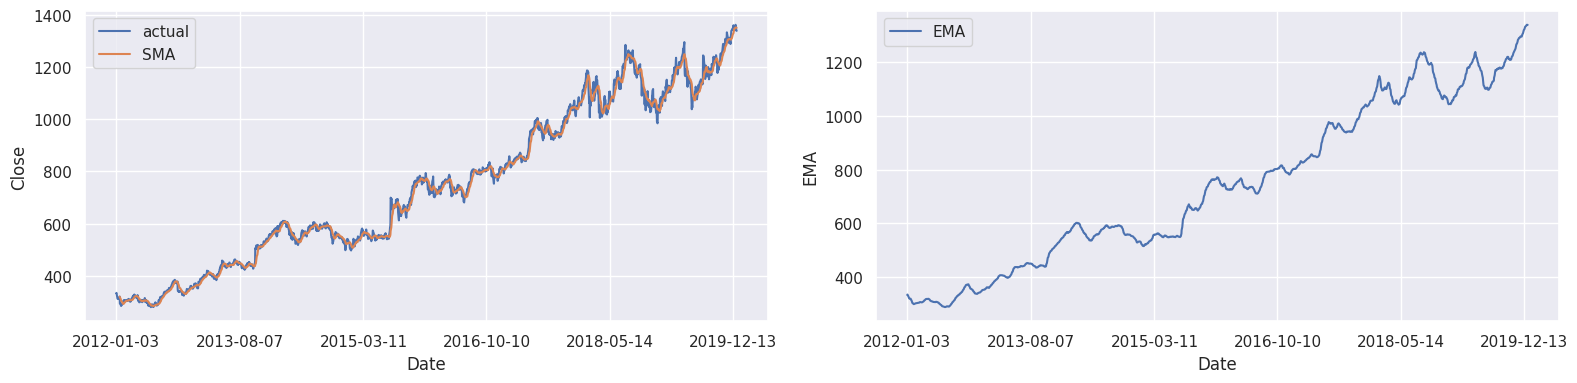

In [28]:
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(16,4))

sns.lineplot(data=df_copy,x='Date',y='Close',ax=ax0,label='actual')
sns.lineplot(data=df_copy,x='Date',y='SMA(12)',ax=ax0,label='SMA')
sns.lineplot(data=df_copy,x='Date',y='EMA',ax=ax1,label='EMA')

ax0.set(xticks=df_copy['Date'].iloc[::400])
ax1.set(xticks=df_copy['Date'].iloc[::400])

plt.legend()

plt.tight_layout()
plt.show()

In [29]:
train_test_split_ratio = 0.8
window_size = 50
split_indx = int(df_copy.shape[0]*train_test_split_ratio)

train_arima = df_copy['EMA'].iloc[:split_indx+window_size]
test_arima = df_copy['EMA'].iloc[split_indx+window_size:]

model_arima = ARIMA(train_arima,order=(4,1,1)).fit()
model_auto_arima = pm.auto_arima(train_arima,stepwise=False,seasonal=False)
predictions_arima = model_arima.forecast(steps=len(test_arima))
predictions_auto_arima = model_auto_arima.predict(n_periods=len(test_arima))

In [30]:
model_auto_arima

ARIMA(order=(0, 2, 5), scoring_args={}, suppress_warnings=True)

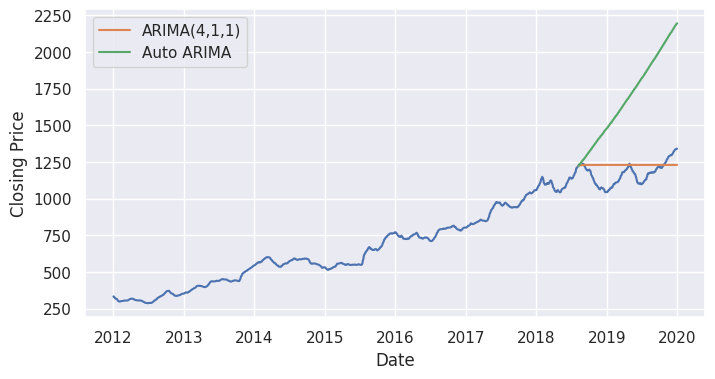

In [31]:
plt.figure(figsize=(8,4))

plt.plot(df_copy['Date'],df_copy['EMA'])
plt.plot(df_copy['Date'].iloc[split_indx+window_size:], predictions_arima,label='ARIMA(4,1,1)')
plt.plot(df_copy['Date'].iloc[split_indx+window_size:], predictions_auto_arima,label='Auto ARIMA')

plt.gca().set(xlabel='Date',ylabel='Closing Price')
plt.legend()

plt.show()

In [32]:
print(f'The error in the ARIMA(4,1,1) model : {mse_loss(test_arima,predictions_arima)}')
print(f'The error in the Auto ARIMA model : {mse_loss(test_arima,predictions_auto_arima)}')

The error in the ARIMA(4,1,1) model : 93.89790018528927
The error in the Auto ARIMA model : 578.9211417059672


## LSTM Neural Network

In [67]:
## Parameters

nrows = df_copy.shape[0]
horizon = 1
train_split_ratio = 0.8

## Hyperparameters

WINDOW_SIZE = 50   # Window to create training series, same as before
NUM_LAYERS = 2
DROPOUT = 0.2

## scaling

feature = 'Return'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copy[feature].values.reshape(-1,1)).flatten()

split_index = int(nrows * train_split_ratio)
df_train_scaled = df_scaled[:split_index]
df_val_scaled = df_scaled[split_index:]

print(f"Train shape: {df_train_scaled.shape}")
print(f"Validation shape: {df_val_scaled.shape}")

Train shape: (1609,)
Validation shape: (403,)


In [68]:
def create_tensors_using_window(data, window_size, horizon):
    """
    Creates inputs (X) and labels (y) from time series dataframe.
    dataframe shape: (n_series, n_steps)
    Output X shape: (n_samples, window_size, 1) 
    Output y shape: (n_samples, window_size, 1)
    """
    X, y = [], []
    n_steps = data.shape[0]
    for j in range(n_steps - window_size):
        window = data[j:(j + window_size)]
        target = data[(j + window_size):(j + window_size + horizon)]
        X.append(window)
        y.append(target)

    return torch.tensor(np.array(X),dtype=torch.float32), torch.tensor(np.array(y).flatten(),dtype=torch.float32)


## Creating training and validation sets

X_train, y_train = create_tensors_using_window(df_train_scaled, WINDOW_SIZE, horizon)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_val, y_val = create_tensors_using_window(df_val_scaled, WINDOW_SIZE, horizon)
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: torch.Size([1559, 50]), y_train shape: torch.Size([1559])
X_val shape: torch.Size([353, 50]), y_val shape: torch.Size([353])


In [69]:
## Using dataloader to create data for training and test

train_dataset = TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset,batch_size=100,num_workers=4,shuffle=True)

val_dataset = TensorDataset(X_val,y_val)
val_dataloader = DataLoader(val_dataset,batch_size=30,num_workers=4,shuffle=True)

In [70]:
class LightningLSTM(L.LightningModule):
    
    def __init__(self):
        
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=1,hidden_size=1,num_layers=NUM_LAYERS,batch_first=True)
        self.dropout = nn.Dropout(p=DROPOUT)
        #self.lstm2 = nn.LSTM(input_size=1,hidden_size=1,num_layers=NUM_LAYERS,dropout=DROPOUT,batch_first=True)
        self.linear = nn.Linear(in_features=1,out_features=1)
        self.WINDOW_SIZE = WINDOW_SIZE

    def forward(self,input):
        
        input_trans = input.reshape(-1,self.WINDOW_SIZE,1)
        #input_trans = input.view(len(input),1) ## (-1,1) also works
        h0,c0 = torch.randn(NUM_LAYERS,input_trans.shape[0],1), torch.randn(NUM_LAYERS,input_trans.shape[0],1)
        lstm_out1,temp = self.lstm1(input_trans, (h0,c0))
        #lstm_dropped = self.dropout(lstm_out1)
        #lstm_out2,temp = self.lstm2(lstm_out1)
        lstm_final = self.linear(lstm_out1)

        predictions = lstm_final[:,-1,0]
            
        return predictions

    def configure_optimizers(self):
        return SGD(self.parameters(),lr=0.1)

    def training_step(self,batch,batch_idx):
        
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = F.mse_loss(output_i,label_i) 

        self.log("train_loss",loss,on_epoch=True)

        return loss

    def validation_step(self,val_batch,batch_idx):
        
        val_input_i, val_label_i = val_batch
        val_output_i = self.forward(val_input_i)
        loss = F.mse_loss(val_output_i,val_label_i)

        self.log("val_loss",loss,on_epoch=True)


In [71]:
model  = LightningLSTM()

In [72]:
start = time.time()

trainer = L.Trainer(max_epochs=200,log_every_n_steps=1)
trainer.fit(model,train_dataloaders=train_dataloader,val_dataloaders=val_dataloader)

end = time.time()

print(f"time elapsed: {end-start} seconds.")

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | lstm1   | LSTM    | 32     | train
1 | dropout | Dropout | 0      | train
2 | linear  | Linear  | 2      | train
--------------------------------------------
34        Trainable params
0         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.


time elapsed: 167.73605251312256 seconds.


In [73]:
horizon_ahead = window_size
last_known_scaled = df_scaled[-2*window_size:-window_size]
forecast_scaled = []


for _ in range(horizon_ahead):
    input_tensor = torch.tensor(last_known_scaled,dtype=torch.float32)
    pred = model(input_tensor).item()
    forecast_scaled.append(pred)
    last_known_scaled = np.append(last_known_scaled[1:], pred)

forecast_unscaled = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()


In [88]:
df_actual = scaler.inverse_transform(df_scaled.reshape(-1,1)).flatten()
df_close = df_actual*df_copy['Close'].shift(1)

forecast_close = forecast_unscaled * df_copy['Close'].shift(1).iloc[-window_size:]

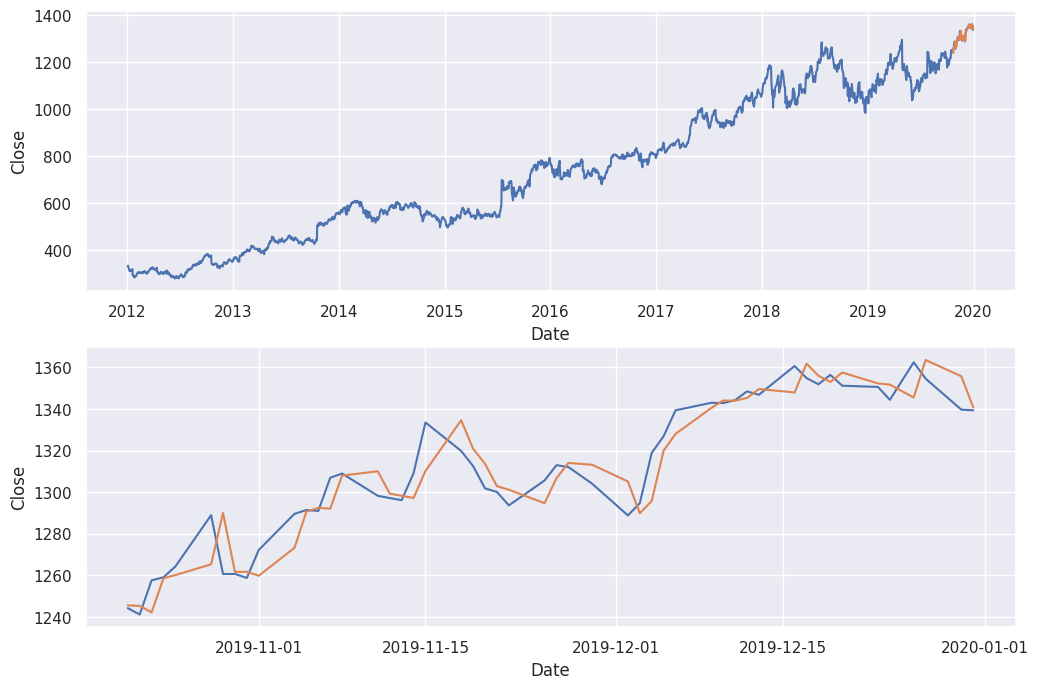

In [96]:
fig,ax = plt.subplots(2,1,figsize=(12,8))

sns.lineplot(x=df_copy['Date'],y=df_copy['Close'],ax=ax[0])
sns.lineplot(x=df_copy['Date'].iloc[-window_size:],y=forecast_close,ax=ax[0])

sns.lineplot(x=df_copy['Date'].iloc[-window_size:],y=df_copy['Close'].iloc[-window_size:],ax=ax[1])
sns.lineplot(x=df_copy['Date'].iloc[-window_size:],y=forecast_close,ax=ax[1])

plt.show()

In [100]:
print(f'The error in the LSTM model : {mse_loss(df_copy.Close.iloc[-window_size:],forecast_close)}')

The error in the LSTM model : 10.870109442718135


## Kolgomorov-Arnold Network (KAN) model

In [45]:
scaler = MinMaxScaler()
df_kan_scaled = scaler.fit_transform(df_copy['EMA'].values.reshape(-1,1)).flatten()
df_kan_scaled.shape

(2012,)

In [46]:
window_size = 50
horizon = 1
train_split_ratio = 0.8

X, y = [], []
n_steps = len(df_kan_scaled)
for j in range(n_steps - window_size):
    window = df_kan_scaled[j:(j + window_size)]
    target = df_kan_scaled[(j + window_size):(j + window_size + horizon)]
    X.append(window)
    y.append(target)

X = torch.tensor(X,dtype=torch.float32)
y = torch.tensor(y,dtype=torch.float32).flatten()

ncols = X.shape[0]
split_index = int(ncols * train_split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index].reshape(-1,1), y[split_index:].reshape(-1,1)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_test.shape}, y_val shape: {y_test.shape}")

X_train shape: torch.Size([1569, 50]), y_train shape: torch.Size([1569, 1])
X_val shape: torch.Size([393, 50]), y_val shape: torch.Size([393, 1])


### Simplistic KAN module

In [80]:
class KolmogorovArnoldNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.decomposition = nn.Linear(input_dim, hidden_dim)
        self.aggregation = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.tanh(self.decomposition(x))
        return self.aggregation(h)


In [81]:
model = KolmogorovArnoldNetwork(window_size, 20, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [84]:
start = time.time()

loss_data = []

for epoch in range(100):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss_data.append(loss.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print(f'epoch {epoch}: finished')

end = time.time()

print(f"time elapsed: {end-start} seconds.")

time elapsed: 0.23802971839904785 seconds.


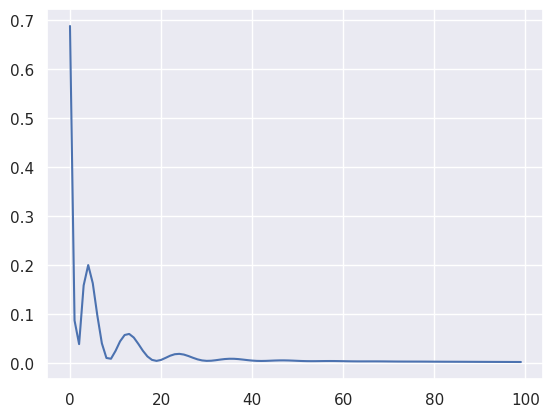

In [85]:
plt.plot(range(100),loss_data)

In [86]:
model.eval()
with torch.no_grad():
    predictions_kan = model(X_test).numpy()
    predictions_kan = scaler.inverse_transform(predictions_kan)
    y_test_actual = scaler.inverse_transform(y_test)

In [106]:
y_test.shape

torch.Size([192, 1])

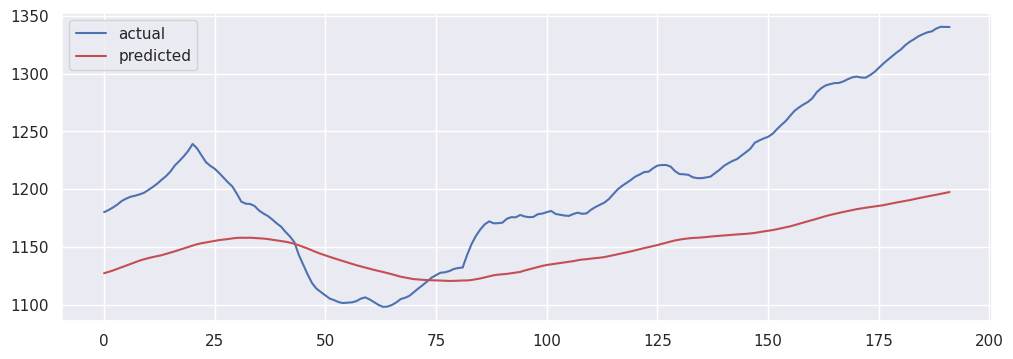

In [98]:
fig,ax = plt.subplots(1,1,figsize=(12,4))

sns.lineplot(x=np.arange(len(y_test_actual)),y=y_test_actual.flatten(),label='actual',ax=ax)
sns.lineplot(x=np.arange(len(y_test_actual)),y=predictions_kan.flatten(),c='r',label='predicted',ax=ax)

#sns.scatterplot(x=y_test_actual.flatten(),y=predictions_kan.flatten(),s=6,c='r',ax=ax1)

plt.show()

In [121]:
horizon_ahead = window_size
last_known_scaled = df_kan_scaled[-2*window_size:-window_size]
forecast_scaled = []

model.eval()
with torch.no_grad():
    for _ in range(horizon_ahead):
        input_tensor = torch.tensor(last_known_scaled,dtype=torch.float32)
        pred = model(input_tensor).item()
        forecast_scaled.append(pred)
        last_known_scaled = np.append(last_known_scaled[1:], pred)

forecast_unscaled = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()


In [117]:
df_kan_actual = scaler.inverse_transform(df_kan_scaled.reshape(-1,1)).flatten()

#plot_data = list(df_kan_actual)

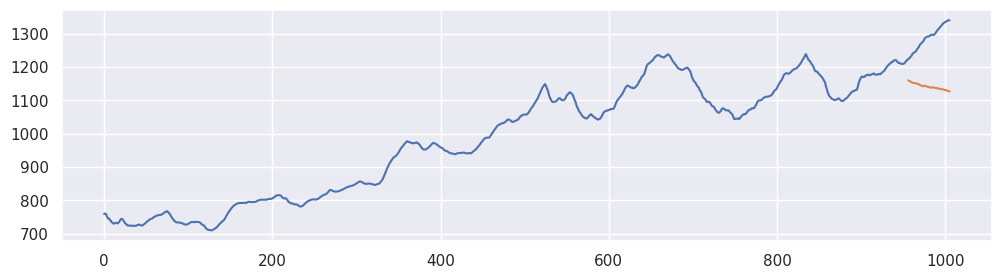

In [122]:
fig,ax = plt.subplots(1,1,figsize=(12,3))

sns.lineplot(x=np.arange(len(df_kan_actual)),y=df_kan_actual,ax=ax)
sns.lineplot(x=np.arange(len(df_kan_actual)-window_size,len(df_kan_actual)),y=forecast_unscaled,ax=ax)

plt.show()

### Pykan module

In [155]:
kanmodel = KAN(width=[3,5,5,3,1], grid=3, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


In [145]:
dataset = {}

dataset['train_input'] = X_train
dataset['test_input'] = X_test
dataset['train_label'] = y_train
dataset['test_label'] = y_test

X = dataset['train_input']
y = dataset['train_label']

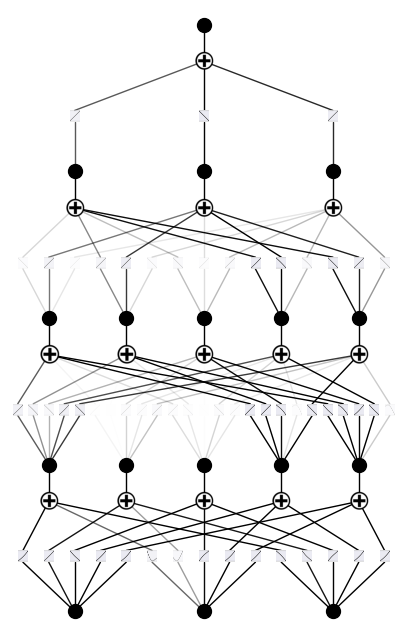

In [146]:
kanmodel(dataset['train_input']);
kanmodel.plot()

In [147]:
def train_acc():
    loss = nn.MSELoss()
    return loss(kanmodel(dataset['train_input']),dataset['train_label'])

def test_acc():
    loss = nn.MSELoss()
    return loss(kanmodel(dataset['test_input']), dataset['test_label'])

In [156]:
kanmodel.fit(dataset, opt='LBFGS', steps=20, metrics=(train_acc, test_acc), loss_fn=nn.MSELoss());

| train_loss: 5.30e-02 | test_loss: 2.09e-01 | reg: 1.99e+01 | : 100%|█| 20/20 [00:12<00:00,  1.65it

saving model version 0.1


saving model version 0.2


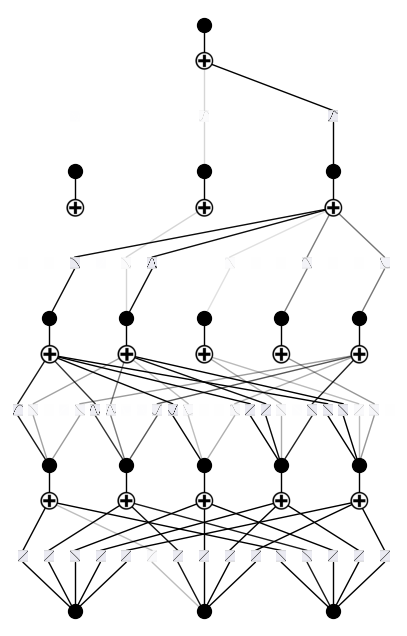

In [157]:
kanmodel = kanmodel.prune()
kanmodel.plot()

In [158]:
kanmodel = kanmodel.prune(node_th = 1e-1)

saving model version 0.3


In [159]:
kanmodel.fit(dataset, opt='LBFGS', steps=50, metrics=(train_acc, test_acc), loss_fn=nn.MSELoss());

| train_loss: 5.51e-02 | test_loss: 1.87e-01 | reg: 1.89e+01 | : 100%|█| 50/50 [00:27<00:00,  1.79it

saving model version 0.4


saving model version 0.5


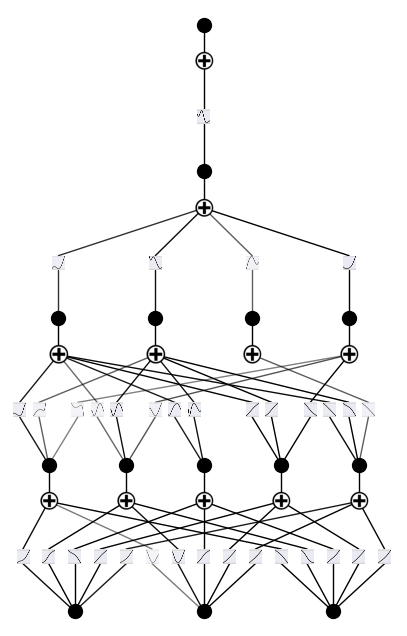

In [160]:
kanmodel = kanmodel.prune(node_th=1e-1)
kanmodel(dataset['train_input'])
kanmodel.plot()

In [161]:
y_pred = kanmodel.forward(dataset['test_input']).detach().numpy().flatten()
y_pred.shape,dataset['test_label'].shape

((192,), torch.Size([192, 1]))

In [162]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_actual = scaler.inverse_transform(dataset['test_label'].reshape(-1,1)).flatten()

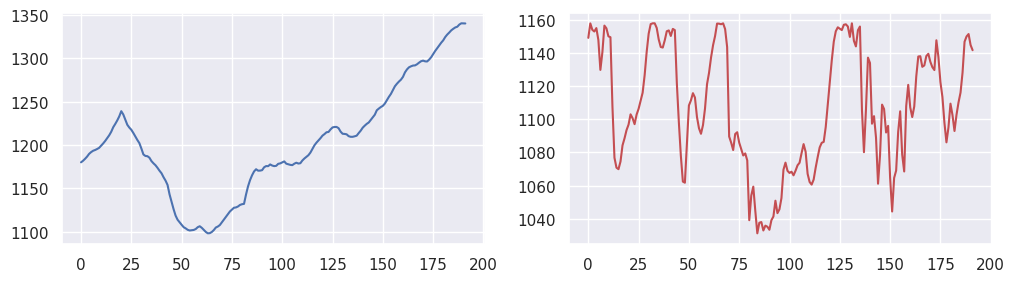

In [163]:
fig,ax = plt.subplots(1,2,figsize=(12,3))

sns.lineplot(x=np.arange(len(y_pred)),y=y_actual,ax=ax[0])
sns.lineplot(x=np.arange(len(y_pred)),y=y_pred,c='r',ax=ax[1])

plt.show()

## Old analysis

In [ ]:
## Pre Crash era

i1,i2 = 100,701

df['Date'] = pd.to_datetime(df['Date'])

df['SMA(20)'] = df['Open'].rolling(window=20).mean()
df['EMA'] = df['Open'].ewm(span=20,adjust=True).mean()
df['CMA'] = df['Open'].expanding(min_periods=20).mean()

plt.figure(figsize=(9,4))
plt.plot(df['Date'][i1:i2],df.iloc[i1:i2,1])
plt.plot(df['Date'][i1:i2],df['SMA(20)'][i1:i2])
plt.plot(df['Date'][i1:i2],df['EMA'][i1:i2])
plt.plot(df['Date'][i1:i2],df['CMA'][i1:i2])

deltaT = (df['Date'][i2]-df['Date'][i1]).total_seconds()
deltaP = (df['Open'][i2]-df['Open'][i1])
slp = deltaP/deltaT
intrcpt = df['Open'][i1]

plt.gca().plot(df['Date'][i1:i2],intrcpt + slp*(df['Date'][i1:i2] - df['Date'][i1]).dt.total_seconds(),ls='dashed',lw=2)

plt.show()

In [ ]:
meanDrift = (df['Log Gain'][i2] - df['Log Gain'][i1])/(deltaT/(3600*24)) ## unit of time 1 day
meanVolatility = np.sqrt(df['Log Gain'][i1:i2].var())

meanDrift,meanVolatility,deltaT

In [ ]:
dataSMA = df['SMA(20)'][i1:i2].dropna()
id1,id2 = pd.Index(df['SMA(20)']).get_loc(dataSMA.values[0]), pd.Index(df['SMA(20)']).get_loc(dataSMA.values[-1])
deltaT = (df['Date'][id2]-df['Date'][id1]).total_seconds()
deltaP = (dataSMA.values[-1]-dataSMA.values[0])
slp = deltaP/(deltaT/(3600*24))
# slp
deltaT

In [ ]:
df.head()

In [ ]:
def create_noise_array(corrCoeff,N):
    means = [0,0]
    covs = np.ones((2,2))*corrCoeff
    np.fill_diagonal(covs,1)

    return np.random.multivariate_normal(means,covs,size=N).T

def update_stock_price(S0,v0,dT,r,theta,omega,zeta,A,B): ## GARCH model
    v = v0 + theta*(omega - v0)*dT + zeta*v0*B*np.sqrt(dT)
    s = S0 + (r - 0.5*v)*S0*dT + np.sqrt(v*dT)*S0*A
    return s,v

def create_paths(T,rho,S0,V0,dT,r,theta,omega,zeta):
    tlocal = 0
    idx = 1
    NT = int(T.array[-1]/dT)+1
    Sarr,Varr = [S0],[V0]
    s0,v0 = S0,V0
    # Sarr[0],Varr[0] = s0,v0
    Noise = create_noise_array(rho,NT)
    for i in range(1,NT):
        # print(f"s0 = {s0},v0 = {v0}")
        s,v = update_stock_price(s0,v0,dT,r,theta,omega,zeta,Noise[0,i-1],Noise[1,i-1])
        s0,v0 = s,v
        tlocal += dT
        # print(round(tlocal,2))
        # if (round(tlocal,1)==T.array[idx]):
            # print(f"idx is {idx}")
        Sarr.append(s),Varr.append(v)
            # idx += 1
        
        # print(f"s = {s},v = {v}")

    return Sarr,Varr

In [ ]:
T = (df['Date'][i1:i2]-df['Date'][i1]).dt.total_seconds()
T = T[:2]
# T = T.array[::2]
dT = 0.1
S0,V0 = df['Open'][0],meanVolatility
rho = 0.7
r,theta,omega,zeta = 0.03,0.05,0.06,0.05

Sarr,Varr = create_paths(T,rho,S0,V0,dT,r,theta,omega,zeta)
# T.array[1]

In [ ]:
dfS = pd.DataFrame(Sarr,columns=['S'])
dfS['V'] = Varr
dfS['Log Gain'] = dfS['S'].apply(lambda x : np.log(x)).diff()
plt.plot(dfS.iloc[i1:601,1])
# dfS.loc[(dfS['S']<=0)].any()

In [ ]:
ntest = create_noise_array(0.2,10000)
a,b,c = plt.hist(ntest[0,:],bins=100)

In [ ]:
a1 = create_noise_array(0,1000)
at1 = a1[0,:].T
at2 = a1[1,:].T

In [ ]:
np.dot(at1,at2),np.sum(at1**2)